In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

df = pd.read_csv(r"C:\Users\andras.janko\Documents\CensusIncomePrediction\_data\adult.csv")
print(f"Shape: {df.shape}")
df.head()

Shape: (32561, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


We can see 32,561 rows and 15 columns.

- Missing values are encoded as ? (e.g., workclass and occupation in row 0)
- Column names use dots instead of underscores (e.g., education.num, marital.status) — we'll clean that up
- Target variable is income with values like <=50K / >50K

# Basic cleanup and info

In [3]:
# Clean column names: dots -> underscores
df.columns = df.columns.str.replace('.', '_', regex=False)

# Strip whitespace from string columns
str_cols = df.select_dtypes(include='object').columns
df[str_cols] = df[str_cols].apply(lambda c: c.str.strip())

# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

print(f"Columns: {list(df.columns)}\n")
print(df.dtypes)
print(f"\nMissing values:\n{df.isnull().sum()[df.isnull().sum() > 0]}")

Columns: ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

Missing values:
workclass         1836
occupation        1843
native_country     583
dtype: int64


Three columns with missing values — workclass (1,836), occupation (1,843), and native_country (583). The counts for workclass and occupation are very close, so they're likely missing together (people not in the labor force).

In [4]:
df.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


- age: ranges 17–90, median 37 — reasonable
- capital_gain / capital_loss: heavily zero-inflated (75th percentile is still 0 for both). capital_gain max of 99,999 looks like a cap/censor value
- hours_per_week: median is exactly 40 (standard work week), max 99 seems like a cap too
- fnlwgt: this is a Census weighting variable, not really a predictive feature — we may want to ignore it later
- education_num: ranges 1–16, an ordinal encoding of education level

# Categorical value counts & target distribution

In [5]:
cat_cols = df.select_dtypes(include='object').columns.tolist()

for col in cat_cols:
    print(f"--- {col} ({df[col].nunique()} unique) ---")
    print(df[col].value_counts().head(10))
    print()

--- workclass (8 unique) ---
workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64

--- education (16 unique) ---
education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
Name: count, dtype: int64

--- marital_status (7 unique) ---
marital_status
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64

--- occupation (14 unique) ---
occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770


- Target is imbalanced: ~76% <=50K vs ~24% >50K — not extreme, but worth keeping in mind
- workclass: dominated by Private (70%). Without-pay and Never-worked are tiny (21 total)
- education: HS-grad is most common; education_num is the numeric version, so one of these is redundant
- marital_status: could be simplified (e.g., all "Married-*" into one group)
- race/sex: dataset skews White (85%) and Male (67%)
- native_country: 90% United-States — very low variance, 41 categories

# Distributions of numeric features + target bar chart

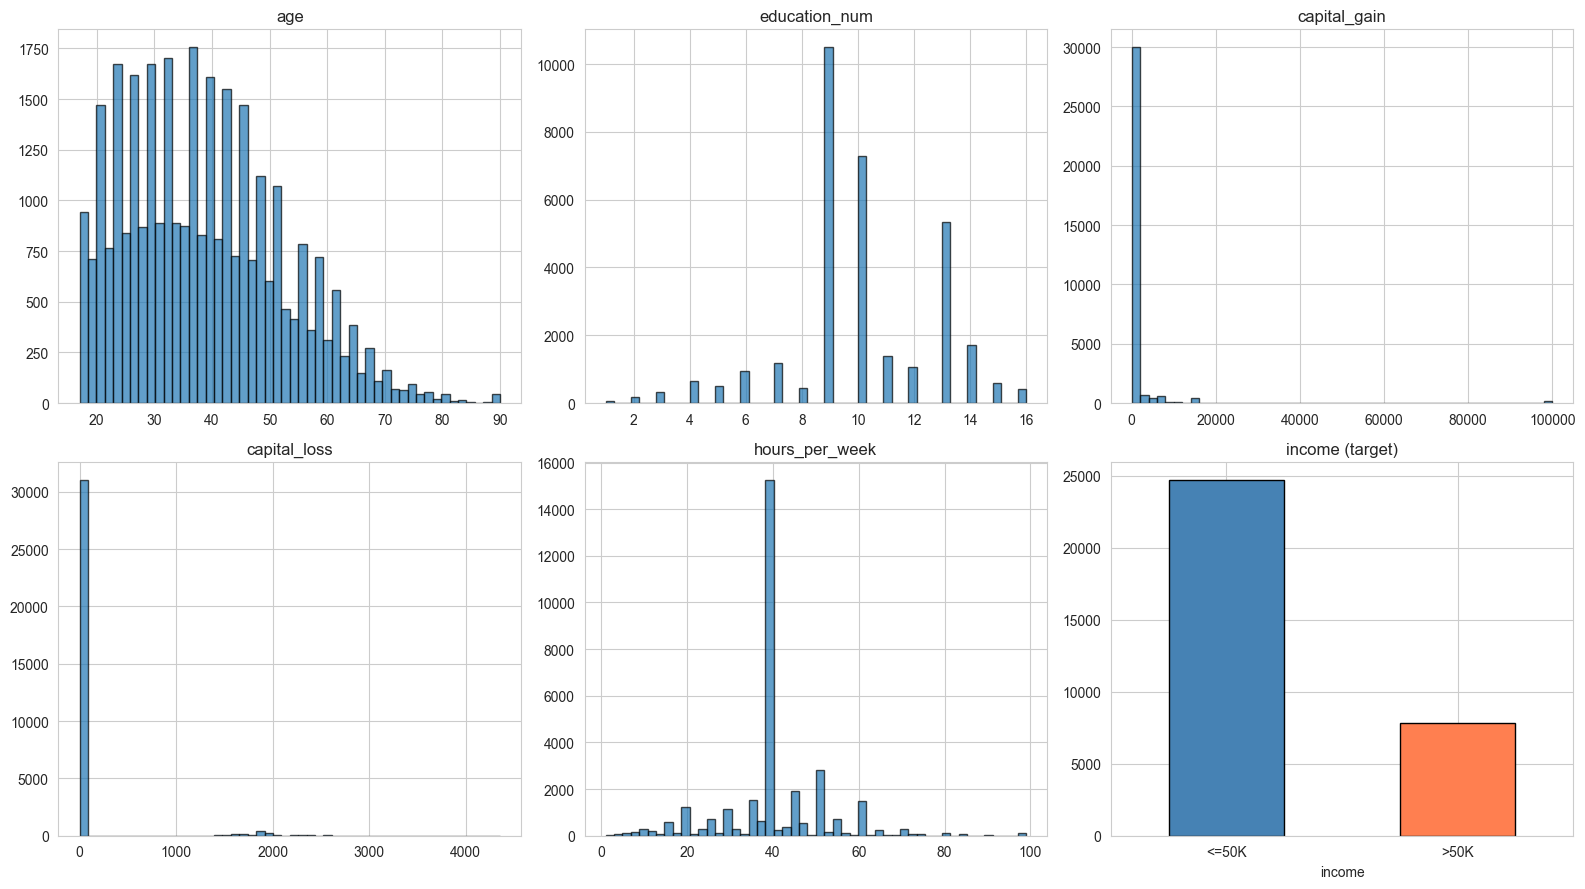

In [6]:
num_cols = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    df[col].hist(bins=50, ax=axes[i], edgecolor='black', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('')

# Target distribution in last subplot
df['income'].value_counts().plot.bar(ax=axes[5], color=['steelblue', 'coral'], edgecolor='black')
axes[5].set_title('income (target)')
axes[5].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

- age: peaks in the 30s (working-age population), tapers off toward 90
- education_num = 9 corresponds to HS-grad (the most common category we saw)
- capital_gain/loss: vast majority are 0 — these are sparse features, only meaningful for the small % who have investment income

# Income breakdown by key features

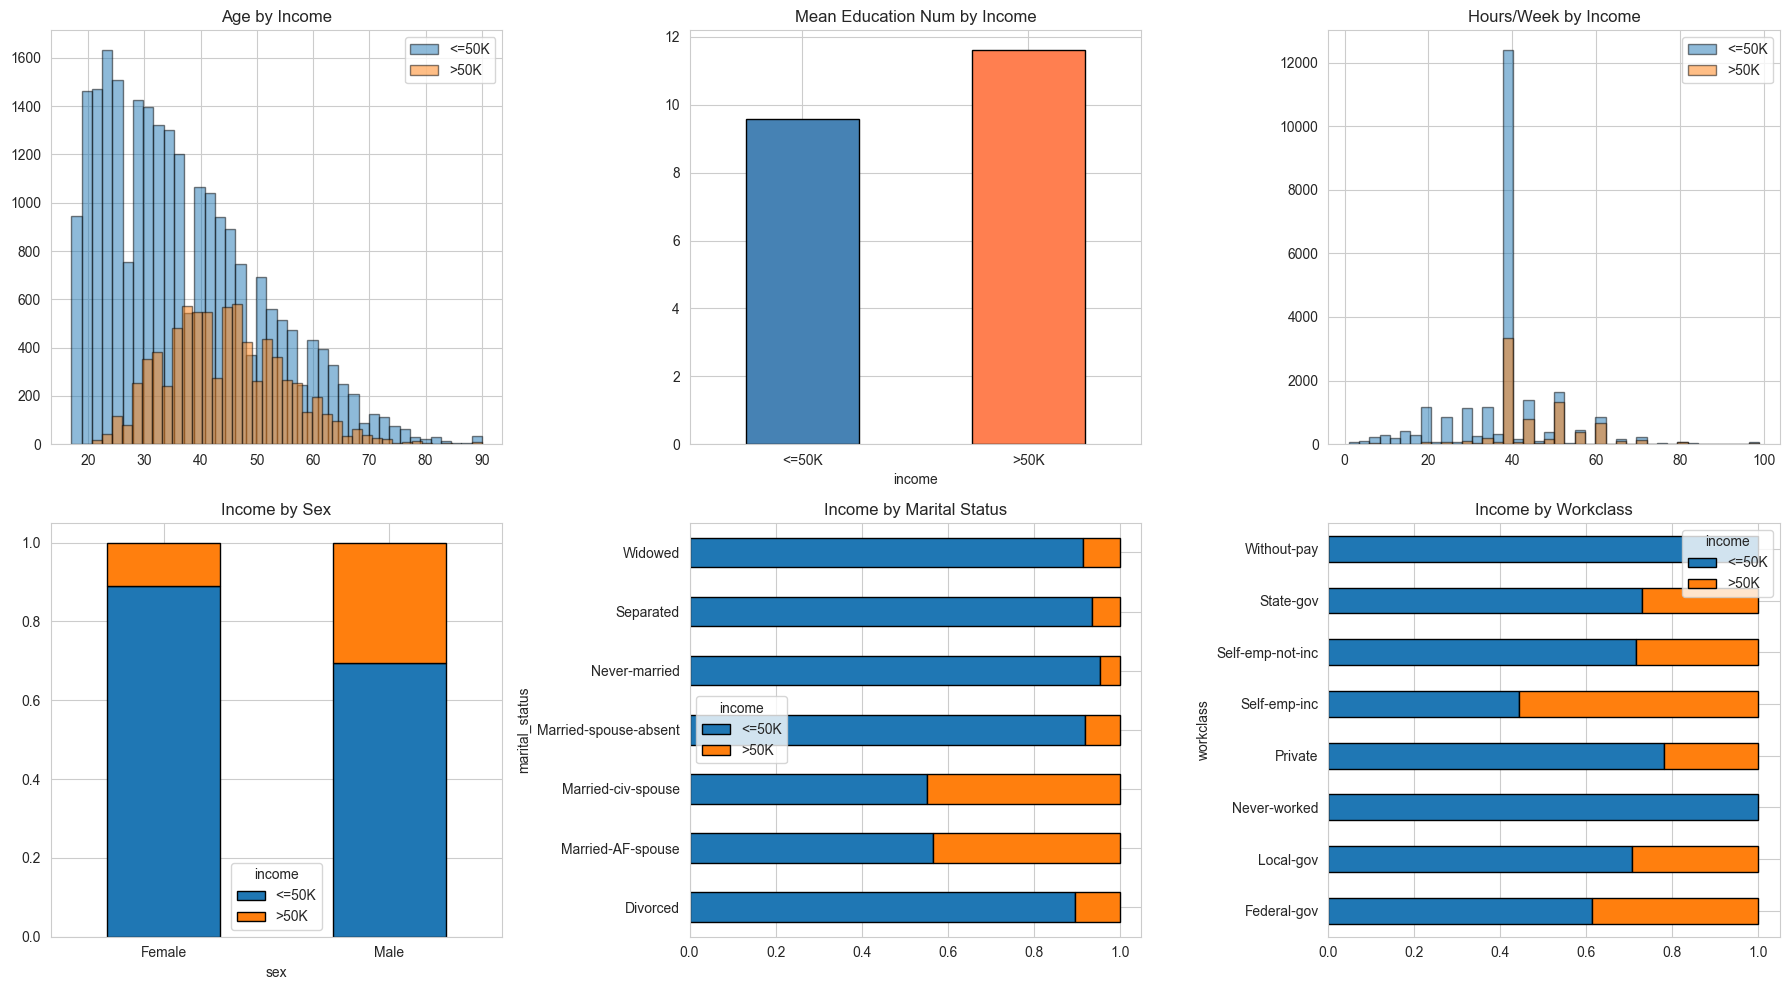

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Age distribution by income
for label, group in df.groupby('income'):
    axes[0, 0].hist(group['age'], bins=40, alpha=0.5, label=label, edgecolor='black')
axes[0, 0].legend()
axes[0, 0].set_title('Age by Income')

# Education num by income
df.groupby('income')['education_num'].mean().plot.bar(ax=axes[0, 1], color=['steelblue', 'coral'], edgecolor='black')
axes[0, 1].set_title('Mean Education Num by Income')
axes[0, 1].tick_params(axis='x', rotation=0)

# Hours per week by income
for label, group in df.groupby('income'):
    axes[0, 2].hist(group['hours_per_week'], bins=40, alpha=0.5, label=label, edgecolor='black')
axes[0, 2].legend()
axes[0, 2].set_title('Hours/Week by Income')

# Income by sex
pd.crosstab(df['sex'], df['income'], normalize='index').plot.bar(stacked=True, ax=axes[1, 0], edgecolor='black')
axes[1, 0].set_title('Income by Sex')
axes[1, 0].tick_params(axis='x', rotation=0)

# Income by marital status
pd.crosstab(df['marital_status'], df['income'], normalize='index').plot.barh(stacked=True, ax=axes[1, 1], edgecolor='black')
axes[1, 1].set_title('Income by Marital Status')

# Income by workclass
pd.crosstab(df['workclass'], df['income'], normalize='index').plot.barh(stacked=True, ax=axes[1, 2], edgecolor='black')
axes[1, 2].set_title('Income by Workclass')

plt.tight_layout()
plt.show()

# Numeric breakdowns by income

In [8]:
# Mean of numeric features by income
print("=== Numeric features by income ===")
print(df.groupby('income')[['age', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss']].mean().round(2))
print()

# Proportion earning >50K by key categorical features
for col in ['sex', 'marital_status', 'workclass', 'race', 'occupation']:
    ct = pd.crosstab(df[col], df['income'], normalize='index').round(3)
    ct.columns.name = None
    ct['count'] = df[col].value_counts()
    ct = ct.sort_values('>50K', ascending=False)
    print(f"=== >50K rate by {col} ===")
    print(ct)
    print()

=== Numeric features by income ===
          age  education_num  hours_per_week  capital_gain  capital_loss
income                                                                  
<=50K   36.78           9.60           38.84        148.75         53.14
>50K    44.25          11.61           45.47       4006.14        195.00

=== >50K rate by sex ===
        <=50K   >50K  count
sex                        
Male    0.694  0.306  21790
Female  0.891  0.109  10771

=== >50K rate by marital_status ===
                       <=50K   >50K  count
marital_status                            
Married-civ-spouse     0.553  0.447  14976
Married-AF-spouse      0.565  0.435     23
Divorced               0.896  0.104   4443
Widowed                0.914  0.086    993
Married-spouse-absent  0.919  0.081    418
Separated              0.936  0.064   1025
Never-married          0.954  0.046  10683

=== >50K rate by workclass ===
                  <=50K   >50K  count
workclass                            
Sel

Numeric features: People earning >50K are on average older (44 vs 37), more educated (11.6 vs 9.6), work more hours (45 vs 39), and have dramatically higher capital gains (4,006 vs 149).

Strongest predictors by >50K rate:
- Marital status: Married-civ-spouse (45%) vs Never-married (5%) — huge gap, likely the single strongest feature
- Occupation: Exec-managerial (48%) and Prof-specialty (45%) at the top; Priv-house-serv (0.7%) at the bottom
- Workclass: Self-emp-inc (56%) stands out — business owners
- Sex: Male (31%) vs Female (11%) — significant disparity
- Race: relatively smaller differences, Asian-Pac-Islander and White slightly higher

# Correlation matrix + capital_gain non-zero distribution

In [9]:
# Encode target for correlation
df['income_binary'] = (df['income'] == '>50K').astype(int)

corr_cols = ['age', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss', 'income_binary']
print("=== Correlation matrix ===")
print(df[corr_cols].corr().round(3))
print()

# Capital gain - non-zero only
cg_nonzero = df[df['capital_gain'] > 0]['capital_gain']
print(f"=== Capital Gain (non-zero): {len(cg_nonzero)} rows ({len(cg_nonzero)/len(df)*100:.1f}%) ===")
print(cg_nonzero.describe().round(1))
print(f"\nValue 99999 count: {(df['capital_gain'] == 99999).sum()}")

# Capital loss - non-zero only
cl_nonzero = df[df['capital_loss'] > 0]['capital_loss']
print(f"\n=== Capital Loss (non-zero): {len(cl_nonzero)} rows ({len(cl_nonzero)/len(df)*100:.1f}%) ===")
print(cl_nonzero.describe().round(1))

=== Correlation matrix ===
                  age  education_num  hours_per_week  capital_gain  \
age             1.000          0.037           0.069         0.078   
education_num   0.037          1.000           0.148         0.123   
hours_per_week  0.069          0.148           1.000         0.078   
capital_gain    0.078          0.123           0.078         1.000   
capital_loss    0.058          0.080           0.054        -0.032   
income_binary   0.234          0.335           0.230         0.223   

                capital_loss  income_binary  
age                    0.058          0.234  
education_num          0.080          0.335  
hours_per_week         0.054          0.230  
capital_gain          -0.032          0.223  
capital_loss           1.000          0.151  
income_binary          0.151          1.000  

=== Capital Gain (non-zero): 2712 rows (8.3%) ===
count     2712.0
mean     12938.5
std      22395.4
min        114.0
25%       3411.0
50%       7298.0
75%    

Correlation insights:
- education_num has the strongest linear correlation with income (0.335)
- age (0.234) and hours_per_week (0.230) follow
- capital_gain (0.223) is notable despite being 92% zeros
- Numeric features are mostly uncorrelated with each other — good for modeling, low multicollinearity

Capital gain/loss:
- Only 8.3% of people have any capital gain, 4.7% any capital loss
- 159 people are capped at 99,999 — likely a Census data ceiling
- These are sparse but potentially powerful signals of wealth

# Missing value patterns + education redundancy check

In [10]:
# Do workclass and occupation tend to be missing together?
both_missing = df['workclass'].isna() & df['occupation'].isna()
either_missing = df['workclass'].isna() | df['occupation'].isna()
print(f"Both workclass & occupation missing: {both_missing.sum()}")
print(f"Either missing: {either_missing.sum()}")
print(f"Only one missing: {either_missing.sum() - both_missing.sum()}")
print()

# Is education_num a perfect mapping of education?
edu_map = df.groupby('education')['education_num'].nunique()
print(f"Each education level maps to exactly 1 education_num? {(edu_map == 1).all()}")
print()
print("=== Education -> education_num mapping ===")
print(df.groupby('education')['education_num'].first().sort_values())

Both workclass & occupation missing: 1836
Either missing: 1843
Only one missing: 7

Each education level maps to exactly 1 education_num? True

=== Education -> education_num mapping ===
education
Preschool        1
1st-4th          2
5th-6th          3
7th-8th          4
9th              5
10th             6
11th             7
12th             8
HS-grad          9
Some-college    10
Assoc-voc       11
Assoc-acdm      12
Bachelors       13
Masters         14
Prof-school     15
Doctorate       16
Name: education_num, dtype: int64


- 1,836 out of 1,843 missing cases overlap — these are almost certainly people not in the labor force
- education and education_num are redundant — perfect 1-to-1 mapping, so we can drop education and keep the numeric version

# Numeric features by income

=== Mean of numeric features by income ===
          age  education_num  hours_per_week  capital_gain  capital_loss
income                                                                  
<=50K   36.78           9.60           38.84        148.75         53.14
>50K    44.25          11.61           45.47       4006.14        195.00



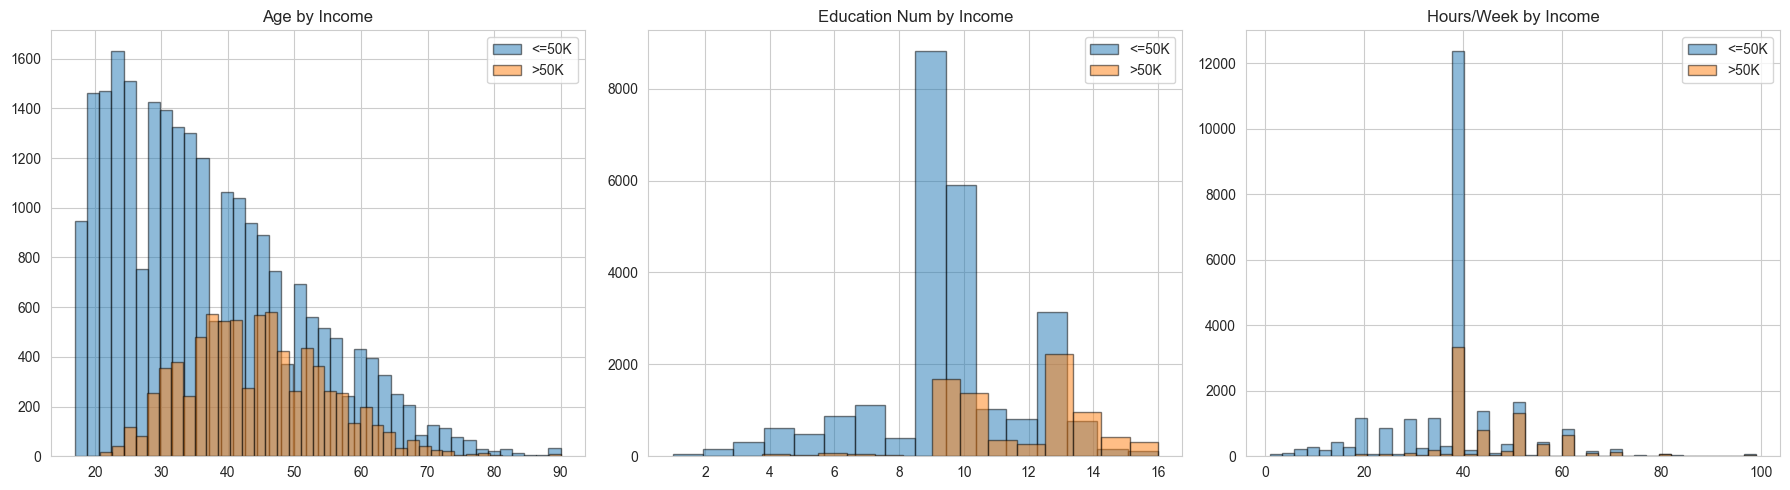

In [11]:
# Text summary
print("=== Mean of numeric features by income ===")
print(df.groupby('income')[['age', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss']].mean().round(2))
print()

# Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age by income
for label, group in df.groupby('income'):
    axes[0].hist(group['age'], bins=40, alpha=0.5, label=label, edgecolor='black')
axes[0].legend()
axes[0].set_title('Age by Income')

# Education num by income
for label, group in df.groupby('income'):
    axes[1].hist(group['education_num'], bins=16, alpha=0.5, label=label, edgecolor='black')
axes[1].legend()
axes[1].set_title('Education Num by Income')

# Hours per week by income
for label, group in df.groupby('income'):
    axes[2].hist(group['hours_per_week'], bins=40, alpha=0.5, label=label, edgecolor='black')
axes[2].legend()
axes[2].set_title('Hours/Week by Income')

plt.tight_layout()
plt.show()

# Categorical features by income

=== >50K rate by sex ===
income  <=50K   >50K  count
sex                        
Male    0.694  0.306  21790
Female  0.891  0.109  10771

=== >50K rate by marital_status ===
income                 <=50K   >50K  count
marital_status                            
Married-civ-spouse     0.553  0.447  14976
Married-AF-spouse      0.565  0.435     23
Divorced               0.896  0.104   4443
Widowed                0.914  0.086    993
Married-spouse-absent  0.919  0.081    418
Separated              0.936  0.064   1025
Never-married          0.954  0.046  10683

=== >50K rate by workclass ===
income            <=50K   >50K  count
workclass                            
Self-emp-inc      0.443  0.557   1116
Federal-gov       0.614  0.386    960
Local-gov         0.705  0.295   2093
Self-emp-not-inc  0.715  0.285   2541
State-gov         0.728  0.272   1298
Private           0.781  0.219  22696
Never-worked      1.000  0.000      7
Without-pay       1.000  0.000     14

=== >50K rate by occupatio

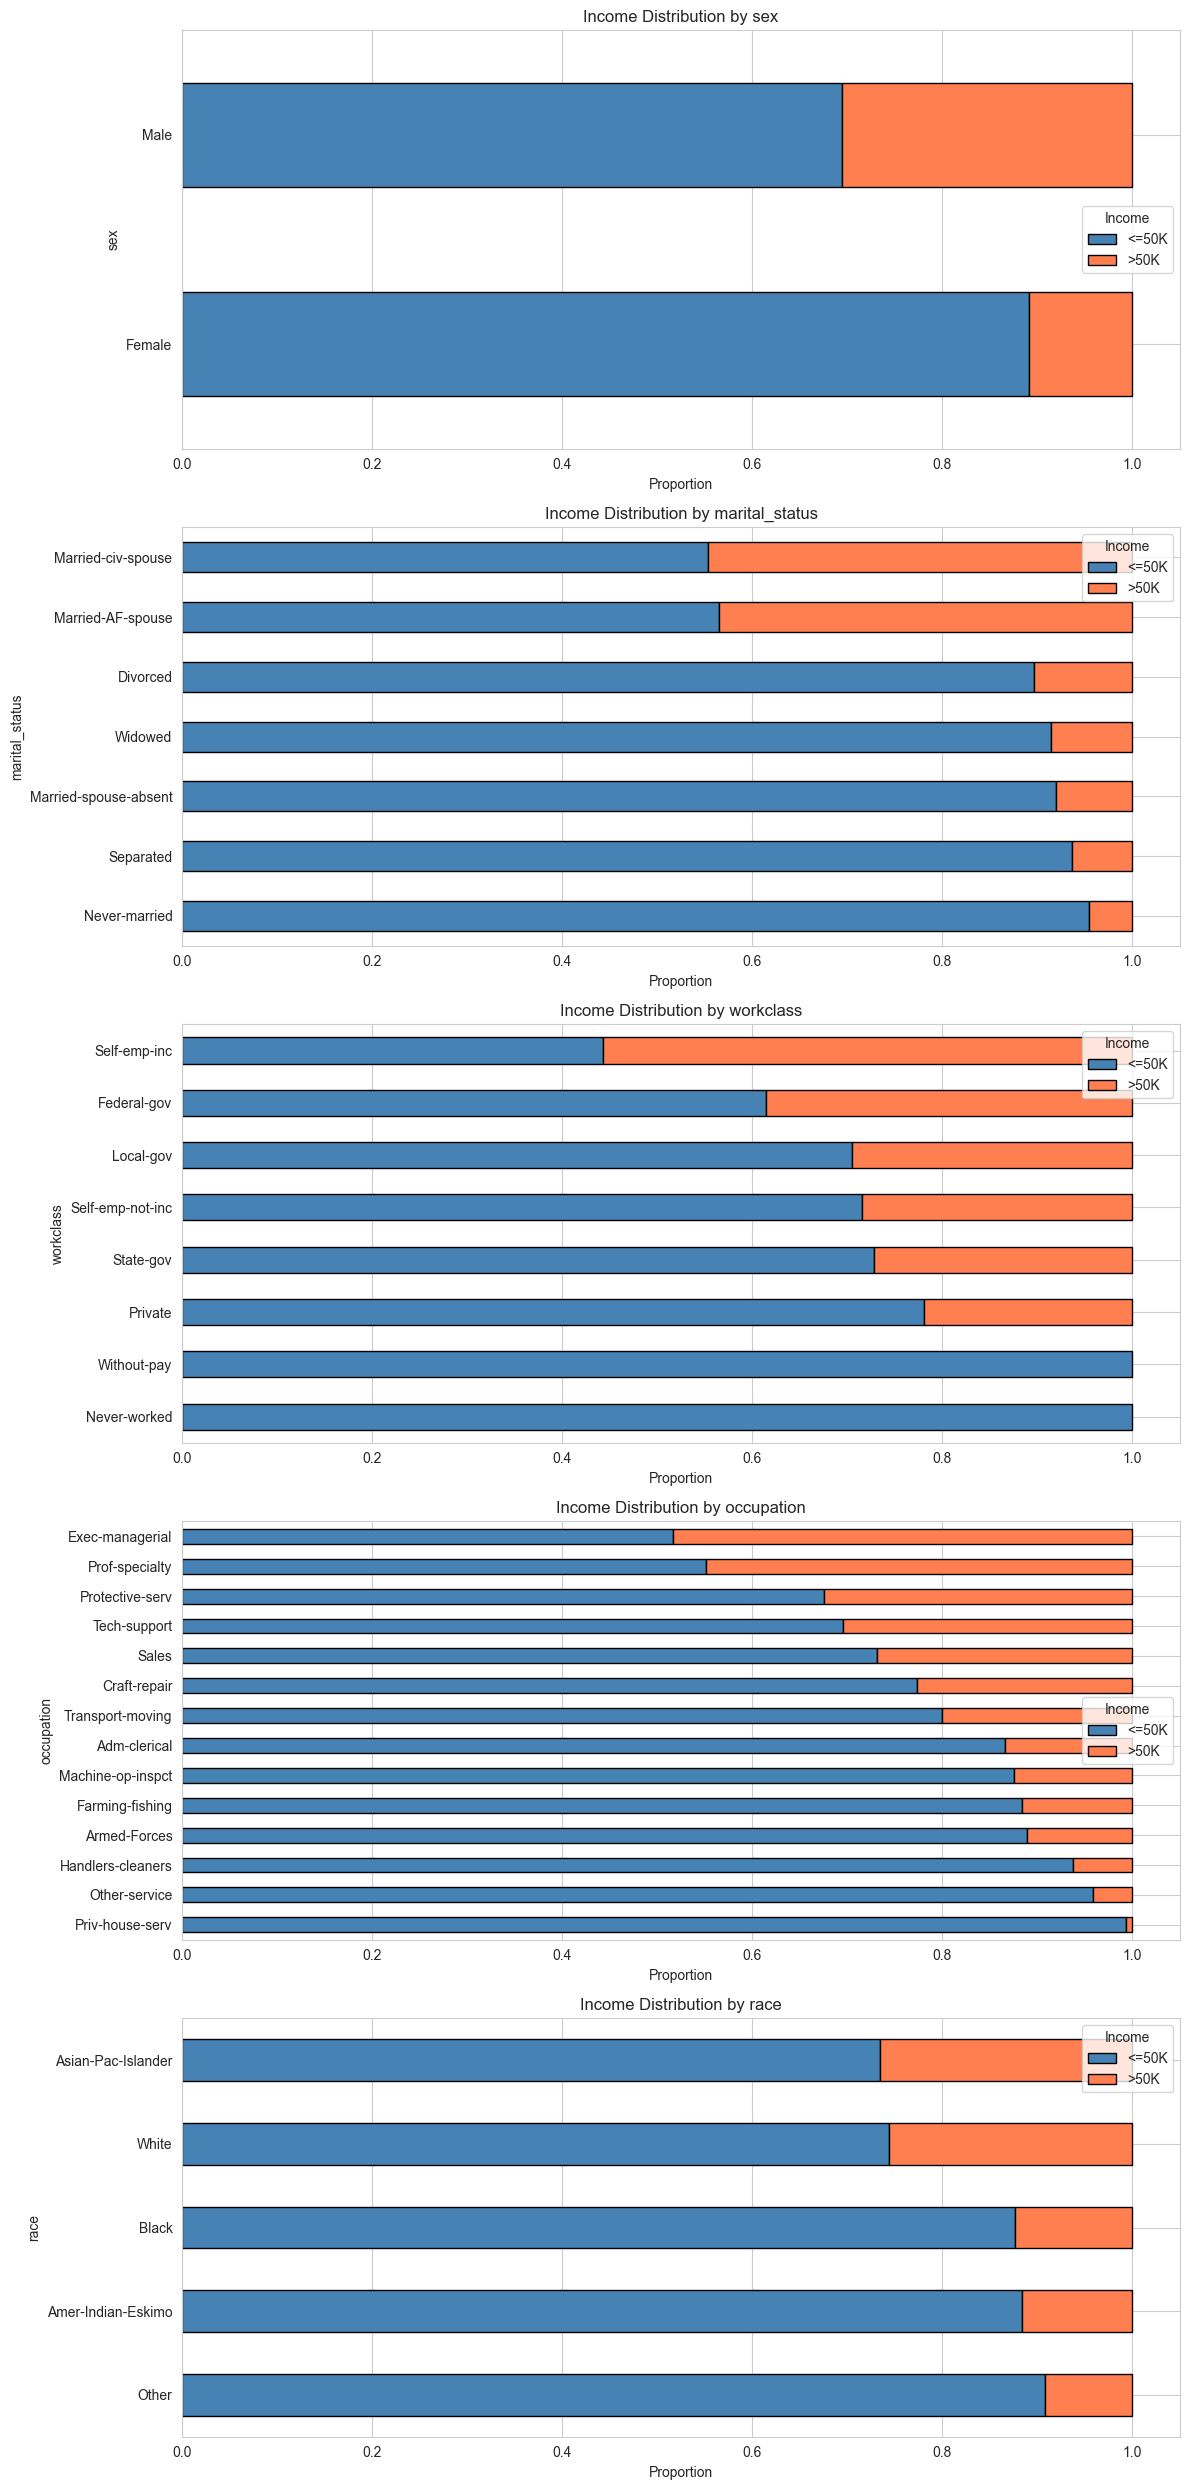

In [12]:
cat_features = ['sex', 'marital_status', 'workclass', 'occupation', 'race']

fig, axes = plt.subplots(len(cat_features), 1, figsize=(12, 25))

for i, col in enumerate(cat_features):
    ct = pd.crosstab(df[col], df['income'], normalize='index').round(3)
    ct = ct.sort_values('>50K', ascending=True)

    # Print text
    ct_display = ct.copy()
    ct_display['count'] = df[col].value_counts()
    print(f"=== >50K rate by {col} ===")
    print(ct_display.sort_values('>50K', ascending=False))
    print()

    # Plot
    ct.plot.barh(stacked=True, ax=axes[i], color=['steelblue', 'coral'], edgecolor='black')
    axes[i].set_title(f'Income Distribution by {col}')
    axes[i].set_xlabel('Proportion')
    axes[i].legend(title='Income')

plt.tight_layout()
plt.show()

# Correlation heatmap

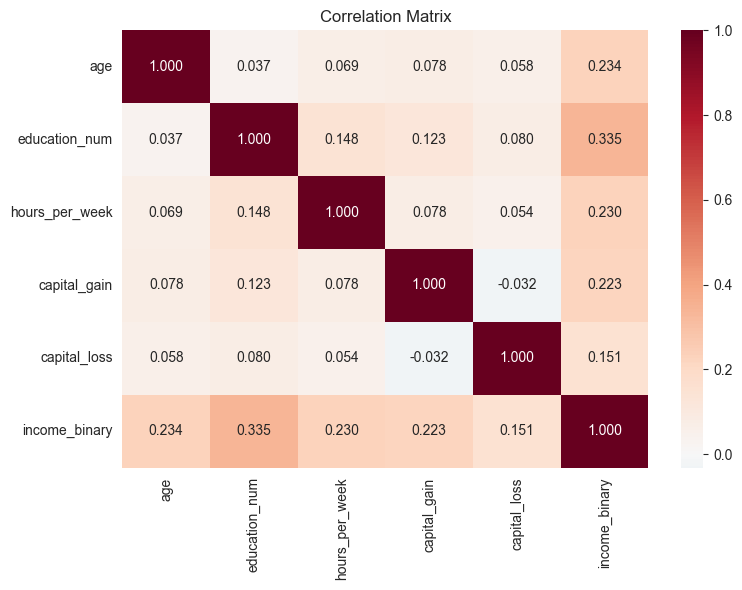

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
corr_cols = ['age', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss', 'income_binary']
corr = df[corr_cols].corr().round(3)
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, fmt='.3f', ax=ax)
ax.set_title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Summary

- DATASET: 32,561 rows, 15 columns (6 numeric, 9 categorical)
- TARGET:  income — 76% <=50K, 24% >50K (imbalanced)

MISSING VALUES:
  - workclass (1,836) & occupation (1,843) — 99.6% overlap, likely not in labor force
  - native_country (583)

REDUNDANCY:
  - education & education_num are perfectly mapped — drop education or the other way around
  - fnlwgt is a Census weight, not a predictive feature

STRONGEST PREDICTORS OF >50K:
  1. marital_status   — Married-civ-spouse: 45% vs Never-married: 5%
  2. occupation       — Exec-managerial: 48% vs Priv-house-serv: 0.7%
  3. education_num    — correlation 0.335 (highest numeric)
  4. workclass        — Self-emp-inc: 56% vs Private: 22%
  5. age              — correlation 0.234, mean 44 vs 37
  6. hours_per_week   — correlation 0.230, mean 45 vs 39
  7. sex              — Male: 31% vs Female: 11%
  8. capital_gain     — 92% zeros, but mean 4,006 vs 149 for >50K

NOTES FOR MODELING:
  - capital_gain/loss: consider binary flag (has/hasn't) + log transform
  - capital_gain = 99,999 appears capped (159 rows)
  - native_country: 90% US — low variance, consider US vs non-US
  - marital_status: consider grouping into Married / Not-married
  - Handle missing workclass/occupation: impute or add 'Unknown' category